In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [11]:
df=pd.read_excel('/content/wilo_timeseries_filtered.xlsx',index_col='Date',parse_dates=True)
df.index.freq='d'


In [12]:
df.columns

Index(['Change_COD'], dtype='object')

<Axes: xlabel='Date'>

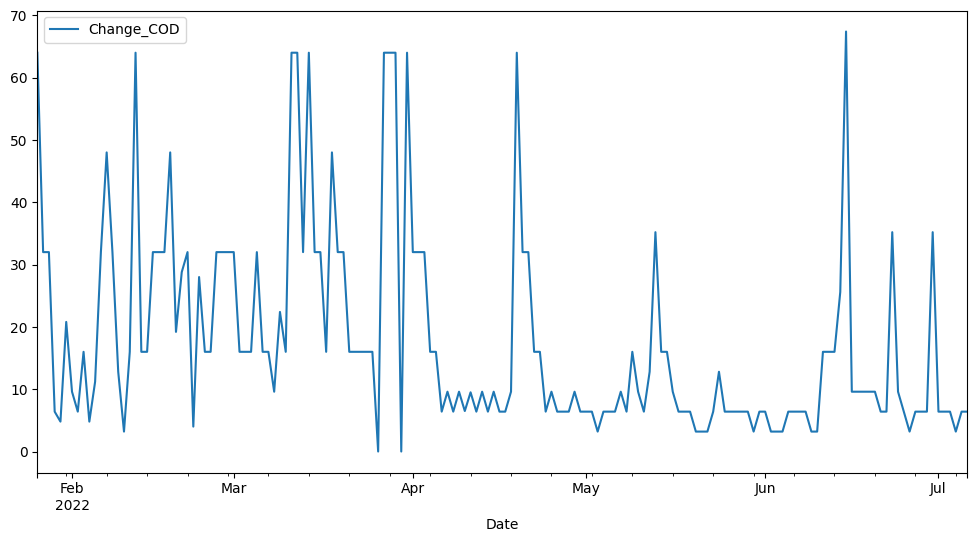

In [13]:
df.plot(figsize=(12,6))

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

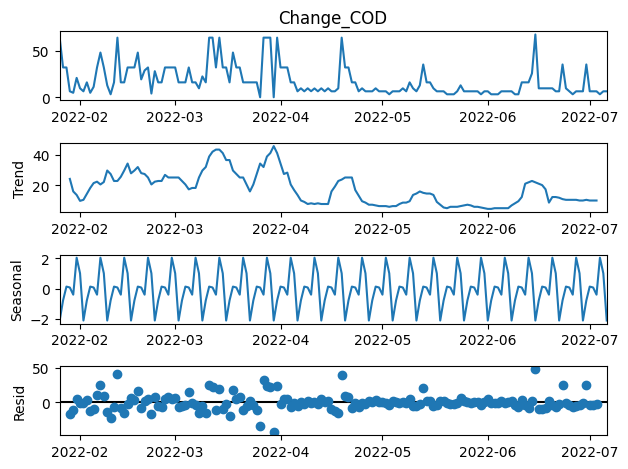

In [15]:
results=seasonal_decompose(df['Change_COD'])
results.plot();

In [16]:
len(df)

162

In [17]:
train=df.iloc[:129]
test=df.iloc[129:]

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [19]:
scaler.fit(train)
scaler_train=scaler.transform(train)
scaler_test=scaler.transform(test)

In [20]:
scaler_train[:10]

array([[1.   ],
       [0.5  ],
       [0.5  ],
       [0.1  ],
       [0.075],
       [0.325],
       [0.15 ],
       [0.1  ],
       [0.25 ],
       [0.075]])

In [21]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
#define genrator
n_input = 12
n_feature=1
generator=TimeseriesGenerator(scaler_train,scaler_train,length=n_input,batch_size=1)

In [23]:
x,y=generator[1]
print(f'Given the Array:\n{x.flatten()}')
print(f'Predict this y:\n{y}')

Given the Array:
[0.5   0.5   0.1   0.075 0.325 0.15  0.1   0.25  0.075 0.175 0.5   0.75 ]
Predict this y:
[[0.5]]


In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [25]:
from keras.engine import sequential
#DEFINE MODEL
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(n_input,n_feature)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [27]:
#fit model
model.fit(generator,epochs=200)

Epoch 1/200
117/117 [==============================] - 3s 9ms/step - loss: 0.0734
Epoch 2/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0591
Epoch 3/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0627
Epoch 4/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0613
Epoch 5/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0603
Epoch 6/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0585
Epoch 7/200
117/117 [==============================] - 1s 10ms/step - loss: 0.0576
Epoch 8/200
117/117 [==============================] - 2s 13ms/step - loss: 0.0564
Epoch 9/200
117/117 [==============================] - 1s 9ms/step - loss: 0.0572
Epoch 10/200
117/117 [==============================] - 1s 10ms/step - loss: 0.0570
Epoch 11/200
117/117 [==============================] - 1s 9ms/step - loss: 0.0552
Epoch 12/200
117/117 [==============================] - 1s 7ms/step - loss: 0.0549
Epoch 13/2

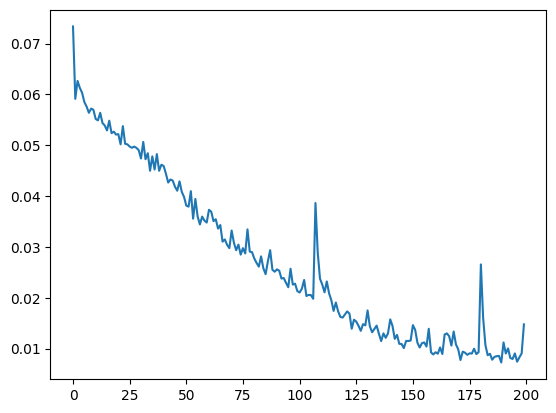

In [28]:
loss_per_epoch=model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [29]:
last_train_batch=scaler_train[-12:]

In [30]:
last_train_batch=last_train_batch.reshape((1,n_input,n_feature))

In [31]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 358ms/step


array([[0.09796228]], dtype=float32)

In [32]:
scaler_test[0]

array([0.05])

In [33]:
test_predictions = []

first_eval_batch = scaler_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_feature))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


1/1 [==============================] - 0s 28ms/step


In [34]:

test_predictions
     

[array([0.09796228], dtype=float32),
 array([0.07895578], dtype=float32),
 array([0.08715935], dtype=float32),
 array([0.09124375], dtype=float32),
 array([0.10014328], dtype=float32),
 array([0.11122365], dtype=float32),
 array([0.12049008], dtype=float32),
 array([0.17566676], dtype=float32),
 array([0.15444416], dtype=float32),
 array([0.17700186], dtype=float32),
 array([0.21014398], dtype=float32),
 array([0.21448155], dtype=float32),
 array([0.20074795], dtype=float32),
 array([0.19507062], dtype=float32),
 array([0.21385439], dtype=float32),
 array([0.2096263], dtype=float32),
 array([0.20281439], dtype=float32),
 array([0.21287929], dtype=float32),
 array([0.16846317], dtype=float32),
 array([0.35895953], dtype=float32),
 array([0.29137543], dtype=float32),
 array([0.4722269], dtype=float32),
 array([0.47593176], dtype=float32),
 array([0.45629317], dtype=float32),
 array([0.4516164], dtype=float32),
 array([0.47441876], dtype=float32),
 array([0.403525], dtype=float32),
 array

In [35]:
true_predictions = scaler.inverse_transform(test_predictions)

In [36]:
test['Prediction']=true_predictions

<ipython-input-36-caa2c9f292f4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction']=true_predictions


<Axes: xlabel='Date'>

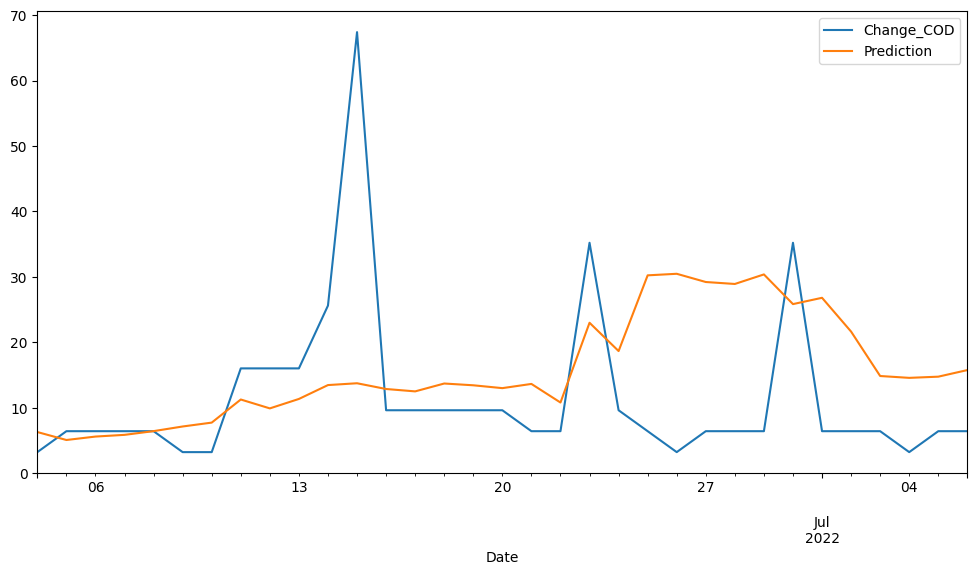

In [37]:
test.plot(figsize=(12,6))

In [38]:
train_predictions = []

first_eval_batch = scaler_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_feature))

for i in range(len(train)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 31ms/step


In [50]:
print(test.head())

            Change_COD  Prediction
Date                              
2022-06-04         3.2    6.269586
2022-06-05         6.4    5.053170
2022-06-06         6.4    5.578198
2022-06-07         6.4    5.839600
2022-06-08         6.4    6.409170


In [53]:
expected=test['Change_COD']
predictions=test['Prediction']

In [54]:
forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]
print('Forecast Errors: %s' % forecast_errors)

Forecast Errors: [-3.0695860862731976, 1.3468302726745591, 0.8218015670776353, 0.5603999137878404, -0.009170150756837359, -3.9183133125305147, -4.511365222930905, 4.757327079772949, 6.115573883056641, 4.671880722045898, 12.15078506469726, 53.67318096160889, -3.247868919372536, -2.8845199584960994, -4.086680793762213, -3.8160833358764705, -3.3801206588745174, -7.224274253845209, -4.381642913818354, 12.226590347290028, -9.048027420043951, -23.822520828247065, -27.259632873535153, -22.802762603759774, -22.503450012207026, -23.962800598144526, 9.374400329589847, -20.38975486755372, -15.222875213623041, -8.434275245666498, -11.35139732360841, -8.332562065124506, -9.341487503051752]


In [52]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test['Change_COD'],test['Prediction'])
print('MAE: %f' % mae)

MAE: 10.566665


In [41]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Change_COD'],test['Prediction']))
print(rmse)

15.101450840856478
